## Подбор гиперпараметров

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import joblib
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

🎯 04: ГИПЕРПАРАМЕТРИЧЕСКИЙ ТЮНИНГ (БЕЗ УТЕЧЕК)

📥 Загрузка данных...
✓ Данные подготовлены: 25 признаков, 421570 записей

🔍 Определение типов признаков...
🔍 Определение типов признаков...
✓ Найдено: 11 числовых признаков
✓ Найдено: 14 категориальных признаков

🎯 КОНФИГУРАЦИЯ МОДЕЛЕЙ

📊 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ (2 фолда)

🔬 RandomForest Baseline
✓ RMSE=16815.2±3249.2
✓ MAE=9670.2, R²=0.240

🔬 LightGBM Baseline
✓ RMSE=15063.4±2631.4
✓ MAE=8857.6, R²=0.397

🎯 ТЮНИНГ ЛУЧШЕЙ МОДЕЛИ
🎯 Тюнинг лучшей модели: LightGBM

🔍 Random Search (8 итераций)
  Итерация 1/8 - RMSE: 14047.7
  Итерация 3/8 - RMSE: 14278.6
  Итерация 6/8 - RMSE: 14047.7

✓ Лучшие параметры: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 5, 'subsample': 0.8}
✓ Лучший RMSE: 14047.7

📊 ФИНАЛЬНАЯ ОЦЕНКА ВСЕХ МОДЕЛЕЙ

🔬 Финальная оценка на полных данных (3 фолда)
  RandomForest Baseline... 
🔬 RandomForest Baseline
✓ RMSE=15319.3±709.4
✓ MAE=8639.6, R²=0.477
✓
  LightGBM Baseline... 
🔬 LightGBM Baseline

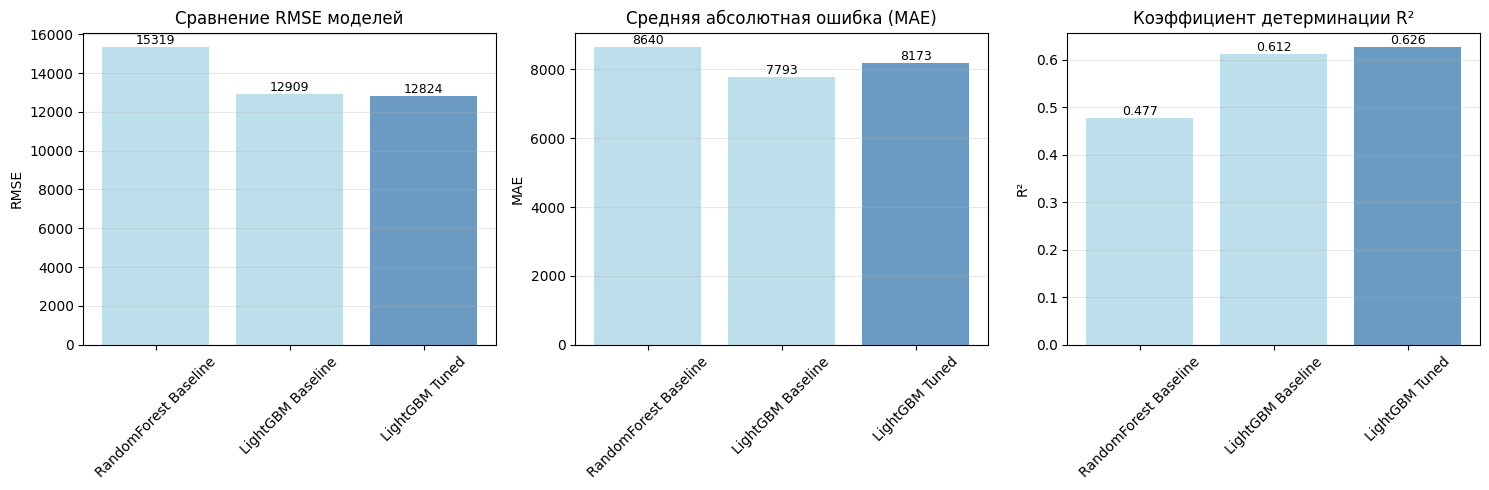


🏆 ВЫБОР И СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ

🏆 ЛУЧШАЯ МОДЕЛЬ: LightGBM Tuned
  RMSE: 12824.1 ± 251.7
  MAE: 8172.8 ± 461.8
  R²: 0.626 ± 0.107
  Улучшение от Baseline: 0.7%

🔧 Финальное обучение лучшей модели на всех данных...
✓ Лучшая модель сохранена: ../reports/improvements/models/final_tuned_safe_model.pkl

📋 ФИНАЛЬНЫЙ ОТЧЕТ


In [ ]:
## 1: Загрузка данных и создание признаков
print("\n📥 Загрузка данных...")

processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
target_col = 'Weekly_Sales'

# Создаем признаки ДО разделения (это безопасно)
df_processed = df.copy()
df_processed['day_of_week'] = df_processed['Date'].dt.dayofweek
df_processed['month'] = df_processed['Date'].dt.month
df_processed['week_of_year'] = df_processed['Date'].dt.isocalendar().week
df_processed['quarter'] = df_processed['Date'].dt.quarter
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['is_december'] = (df_processed['month'] == 12).astype(int)
df_processed['is_summer'] = df_processed['month'].isin([6, 7, 8]).astype(int)

df_processed = df_processed.drop(columns=['Date'])
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"✓ Данные подготовлены: {X.shape[1]} признаков, {X.shape[0]} записей")

## 2: Безопасный трансформер для определения типов признаков
class SafeFeatureIdentifier(BaseEstimator, TransformerMixin):
    """Безопасное определение типов признаков без утечек"""
    
    def __init__(self, numeric_features=None, categorical_features=None):
        self.numeric_features_ = numeric_features or []
        self.categorical_features_ = categorical_features or []
        self.is_fitted_ = False
        
    def fit(self, X, y=None):
        if self.numeric_features_ or self.categorical_features_:
            self._validate_features(X)
            self.is_fitted_ = True
            return self
        
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        self.numeric_features_ = []
        self.categorical_features_ = []
        
        for col in X_df.columns:
            if pd.api.types.is_numeric_dtype(X_df[col]):
                self.numeric_features_.append(col)
            else:
                self.categorical_features_.append(col)
        
        self.is_fitted_ = True
        return self
    
    def transform(self, X):
        if not self.is_fitted_:
            raise ValueError("Transformer must be fitted before transform")
        
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        for col in self.categorical_features_:
            if col in X_df.columns:
                X_df[col] = X_df[col].astype(str).replace('nan', 'missing')
        
        return X_df
    
    def _validate_features(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        all_features = set(self.numeric_features_ + self.categorical_features_)
        data_features = set(X_df.columns)
        
        if not all_features.issubset(data_features):
            missing = all_features - data_features
            raise ValueError(f"Missing features in data: {missing}")

## 3: Функция для предварительного определения признаков
def identify_features_safely(X_sample):
    """Безопасно определяет типы признаков один раз на небольшой выборке"""
    print("🔍 Определение типов признаков...")
    
    numeric_features = []
    categorical_features = []
    
    for col in X_sample.columns:
        if pd.api.types.is_numeric_dtype(X_sample[col]):
            if X_sample[col].nunique() <= 30:
                categorical_features.append(col)
            else:
                numeric_features.append(col)
        else:
            categorical_features.append(col)
    
    print(f"✓ Найдено: {len(numeric_features)} числовых признаков")
    print(f"✓ Найдено: {len(categorical_features)} категориальных признаков")
    
    return numeric_features, categorical_features

## 4: Создание пайплайна с предопределенными признаками
def create_safe_pipeline(estimator, numeric_features, categorical_features):
    """Создает безопасный пайплайн с предопределенными признаками"""
    
    feature_identifier = SafeFeatureIdentifier(
        numeric_features=numeric_features,
        categorical_features=categorical_features
    )
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    
    return Pipeline(steps=[
        ('feature_identifier', feature_identifier),
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

## 5: Безопасная оценка с TimeSeriesSplit
def safe_cv_evaluation(estimator, X, y, numeric_features, categorical_features, 
                      model_name="Model", n_splits=3):
    """Безопасная оценка модели без утечек"""
    
    print(f"\n🔬 {model_name}")
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        pipeline = create_safe_pipeline(estimator, numeric_features, categorical_features)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })
    
    rmse_values = [r['rmse'] for r in fold_results]
    mae_values = [r['mae'] for r in fold_results]
    r2_values = [r['r2'] for r in fold_results]
    
    cv_results = {
        'model_name': model_name,
        'cv_rmse_mean': np.mean(rmse_values),
        'cv_rmse_std': np.std(rmse_values),
        'cv_mae_mean': np.mean(mae_values),
        'cv_mae_std': np.std(mae_values),
        'cv_r2_mean': np.mean(r2_values),
        'cv_r2_std': np.std(r2_values),
        'fold_results': fold_results
    }
    
    print(f"✓ RMSE={cv_results['cv_rmse_mean']:.1f}±{cv_results['cv_rmse_std']:.1f}")
    print(f"✓ MAE={cv_results['cv_mae_mean']:.1f}, R²={cv_results['cv_r2_mean']:.3f}")
    
    return cv_results

## 6: Безопасный random search
def safe_random_search(estimator, param_distributions, X, y, 
                      numeric_features, categorical_features,
                      n_iter=10, n_splits=3):
    """Безопасный случайный поиск без утечек"""
    
    print(f"\n🔍 Random Search ({n_iter} итераций)")
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    best_score = np.inf
    best_params = None
    all_results = []
    
    import random
    
    for i in range(1, n_iter + 1):
        params = {k: random.choice(v) if isinstance(v, list) else v 
                 for k, v in param_distributions.items()}
        
        if i == 1 or i % 3 == 0:
            print(f"  Итерация {i}/{n_iter}", end=" ")
        
        estimator_with_params = estimator.__class__(**estimator.get_params())
        estimator_with_params.set_params(**params)
        
        cv_scores = []
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            pipeline = create_safe_pipeline(estimator_with_params, 
                                           numeric_features, categorical_features)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            score = np.sqrt(mean_squared_error(y_test, y_pred))
            cv_scores.append(score)
        
        mean_score = np.mean(cv_scores)
        
        if i == 1 or i % 3 == 0:
            print(f"- RMSE: {mean_score:.1f}")
        
        all_results.append({
            'iteration': i,
            'params': params,
            'mean_score': mean_score
        })
        
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
    
    print(f"\n✓ Лучшие параметры: {best_params}")
    print(f"✓ Лучший RMSE: {best_score:.1f}")
    
    return best_params, best_score, all_results

## 7: Определение признаков
print("\n🔍 Определение типов признаков...")
X_sample_for_feature_id = X.iloc[:10000]
numeric_features, categorical_features = identify_features_safely(X_sample_for_feature_id)

## 8: Конфигурация моделей
print("\n🎯 КОНФИГУРАЦИЯ МОДЕЛЕЙ")

models_config = {
    'RandomForest': {
        'estimator': RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            n_estimators=100
        ),
        'param_distributions': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    'LightGBM': {
        'estimator': LGBMRegressor(
            random_state=42,
            n_jobs=-1,
            n_estimators=100,
            verbose=-1
        ),
        'param_distributions': {
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [5, 10],
            'subsample': [0.8, 1.0]
        }
    }
}

## 9: Быстрое сравнение базовых моделей
print("\n" + "="*60)
print("📊 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ (2 фолда)")
print("="*60)

baseline_results = {}
for model_name, config in models_config.items():
    results = safe_cv_evaluation(
        config['estimator'], X, y,
        numeric_features, categorical_features,
        model_name=f"{model_name} Baseline",
        n_splits=2
    )
    baseline_results[model_name] = results

## 10: Тюнинг лучшей модели
print("\n" + "="*60)
print("🎯 ТЮНИНГ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

baseline_rmse = {k: v['cv_rmse_mean'] for k, v in baseline_results.items()}
best_model_name = min(baseline_rmse, key=baseline_rmse.get)
print(f"🎯 Тюнинг лучшей модели: {best_model_name}")

best_params, best_rmse, search_results = safe_random_search(
    models_config[best_model_name]['estimator'],
    models_config[best_model_name]['param_distributions'],
    X, y,
    numeric_features, categorical_features,
    n_iter=8,
    n_splits=2
)

## 11: Финальная оценка всех моделей
print("\n" + "="*60)
print("📊 ФИНАЛЬНАЯ ОЦЕНКА ВСЕХ МОДЕЛЕЙ")
print("="*60)

all_models = {}

for model_name in models_config.keys():
    all_models[f"{model_name} Baseline"] = {
        'estimator': models_config[model_name]['estimator'],
        'params': models_config[model_name]['estimator'].get_params()
    }

estimator_cls = models_config[best_model_name]['estimator'].__class__
all_models[f"{best_model_name} Tuned"] = {
    'estimator': estimator_cls(**best_params),
    'params': best_params
}

print("\n🔬 Финальная оценка на полных данных (3 фолда)")
final_results = {}

for model_display_name, model_info in all_models.items():
    print(f"  {model_display_name}...", end=" ")
    
    results = safe_cv_evaluation(
        model_info['estimator'], X, y,
        numeric_features, categorical_features,
        model_name=model_display_name,
        n_splits=3
    )
    
    final_results[model_display_name] = results
    print("✓")

## 12: Сравнение и визуализация
print("\n" + "="*60)
print("📊 ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

comparison_data = []
for model_name, results in final_results.items():
    comparison_data.append({
        'Модель': model_name,
        'RMSE': results['cv_rmse_mean'],
        'RMSE_std': results['cv_rmse_std'],
        'MAE': results['cv_mae_mean'],
        'MAE_std': results['cv_mae_std'],
        'R²': results['cv_r2_mean'],
        'R²_std': results['cv_r2_std'],
        'Тип': 'Baseline' if 'Baseline' in model_name else 'Tuned'
    })

comparison_df = pd.DataFrame(comparison_data)

# Вычисляем улучшение для настроенной модели
tuned_mask = comparison_df['Тип'] == 'Tuned'
if tuned_mask.any():
    tuned_model = comparison_df[tuned_mask].iloc[0]
    base_model_name = tuned_model['Модель'].replace(' Tuned', ' Baseline')
    base_model = comparison_df[comparison_df['Модель'] == base_model_name]
    
    if not base_model.empty:
        base_rmse = base_model['RMSE'].values[0]
        improvement = (base_rmse - tuned_model['RMSE']) / base_rmse * 100
        comparison_df.loc[tuned_mask, 'Улучшение RMSE (%)'] = improvement

print("\nСравнительная таблица:")
print(comparison_df.round({'RMSE': 1, 'RMSE_std': 1, 'MAE': 1, 'MAE_std': 1, 
                          'R²': 3, 'R²_std': 3, 'Улучшение RMSE (%)': 2}))

## 13: Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df['Модель']
rmse_values = comparison_df['RMSE']
mae_values = comparison_df['MAE']
r2_values = comparison_df['R²']
colors = ['lightblue' if 'Baseline' in m else 'steelblue' for m in models]

# RMSE
bars1 = axes[0].bar(models, rmse_values, alpha=0.8, color=colors)
axes[0].set_ylabel('RMSE')
axes[0].set_title('Сравнение RMSE моделей')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars1, rmse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# MAE
bars2 = axes[1].bar(models, mae_values, alpha=0.8, color=colors)
axes[1].set_ylabel('MAE')
axes[1].set_title('Средняя абсолютная ошибка (MAE)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars2, mae_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# R²
bars3 = axes[2].bar(models, r2_values, alpha=0.8, color=colors)
axes[2].set_ylabel('R²')
axes[2].set_title('Коэффициент детерминации R²')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/final_model_comparison_safe.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 14: Выбор и сохранение лучшей модели
print("\n" + "="*60)
print("🏆 ВЫБОР И СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

best_model_name = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Модель']
best_model_results = final_results[best_model_name]

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"  RMSE: {best_model_results['cv_rmse_mean']:.1f} ± {best_model_results['cv_rmse_std']:.1f}")
print(f"  MAE: {best_model_results['cv_mae_mean']:.1f} ± {best_model_results['cv_mae_std']:.1f}")
print(f"  R²: {best_model_results['cv_r2_mean']:.3f} ± {best_model_results['cv_r2_std']:.3f}")

if 'Улучшение RMSE (%)' in comparison_df.columns:
    improvement = comparison_df.loc[comparison_df['Модель'] == best_model_name, 'Улучшение RMSE (%)'].values[0]
    if not pd.isna(improvement):
        print(f"  Улучшение от Baseline: {improvement:.1f}%")

print("\n🔧 Финальное обучение лучшей модели на всех данных...")

if 'Tuned' in best_model_name:
    base_model = best_model_name.replace(' Tuned', '')
    final_estimator = estimator_cls(**best_params)
else:
    final_estimator = all_models[best_model_name]['estimator']

final_pipeline = create_safe_pipeline(final_estimator, numeric_features, categorical_features)
final_pipeline.fit(X, y)

os.makedirs('../reports/improvements/models', exist_ok=True)
model_path = f'../reports/improvements/models/final_tuned_safe_model.pkl'
joblib.dump(final_pipeline, model_path)

print(f"✓ Лучшая модель сохранена: {model_path}")

## 15: Финальный отчет (ИСПРАВЛЕННАЯ версия)
print("\n📋 ФИНАЛЬНЫЙ ОТЧЕТ")

# Извлекаем только метрики для JSON сериализации
best_performance_metrics = {
    'cv_rmse_mean': float(best_model_results['cv_rmse_mean']),
    'cv_rmse_std': float(best_model_results['cv_rmse_std']),
    'cv_mae_mean': float(best_model_results['cv_mae_mean']),
    'cv_mae_std': float(best_model_results['cv_mae_std']),
    'cv_r2_mean': float(best_model_results['cv_r2_mean']),
    'cv_r2_std': float(best_model_results['cv_r2_std'])
}

final_report = {
    'timestamp': datetime.now().isoformat(),
    'best_model': {
        'name': best_model_name,
        'parameters': all_models[best_model_name]['params'],
        'performance': best_performance_metrics,
        'improvement_percent': float(comparison_df.loc[tuned_mask, 'Улучшение RMSE (%)'].values[0]) if tuned_mask.any() else None
    },
    'feature_info': {
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'total_features': len(numeric_features) + len(categorical_features)
    },
    'optimization_summary': {
        'models_tested': len(models_config),
        'best_algorithm': best_model_name.split()[0],
        'random_search_iterations': 8,
        'cv_folds_baseline': 2,
        'cv_folds_final': 3
    },
    'data_leakage_prevention': {
        'feature_identification': 'safe (first 10000 samples)',
        'no_random_subsampling': True,
        'time_series_split_used': True,
        'no_future_data_information': True
    },
    'all_models_comparison': comparison_df.to_dict('records')
}

results_dir = '../reports/improvements/results'
os.makedirs(results_dir, exist_ok=True)

report_path = f'{results_dir}/experiment_4_no_leakage_report.json'
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False, default=str)

comparison_df.to_csv(f'{results_dir}/experiment_4_no_leakage_comparison.csv', index=False)

🎯 04: ГИПЕРПАРАМЕТРИЧЕСКИЙ ТЮНИНГ (Логарифмирование + XGBoost)

📥 Загрузка данных...
✓ Данные: 25 признаков, 421570 записей

🔍 Определение типов признаков...
✓ Числовых: 11, Категориальных: 14

🎯 КОНФИГУРАЦИЯ МОДЕЛЕЙ

📊 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ (2 фолда)

RandomForest Baseline... RMSE: 16971.2, R²: 0.216

LightGBM Baseline... RMSE: 13681.1, R²: 0.514

XGBoost Baseline... RMSE: 15803.0, R²: 0.326

🎯 ТЮНИНГ ЛУЧШИХ МОДЕЛЕЙ
Тюнинг: ['LightGBM', 'XGBoost']

LightGBM...
Random Search (10 итераций)
  Итерация 1/10 - RMSE: 13972.4
  Итерация 5/10 - RMSE: 13855.9
  Итерация 10/10 - RMSE: 13728.5

✓ Лучшие параметры: {'n_estimators': 200, 'learning_rate': 0.01, 'num_leaves': 100, 'max_depth': -1, 'subsample': 0.8}
✓ Лучший RMSE: 12822.9

XGBoost...
Random Search (10 итераций)
  Итерация 1/10 - RMSE: 13692.8
  Итерация 5/10 - RMSE: 15216.7
  Итерация 10/10 - RMSE: 14028.8

✓ Лучшие параметры: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.8}


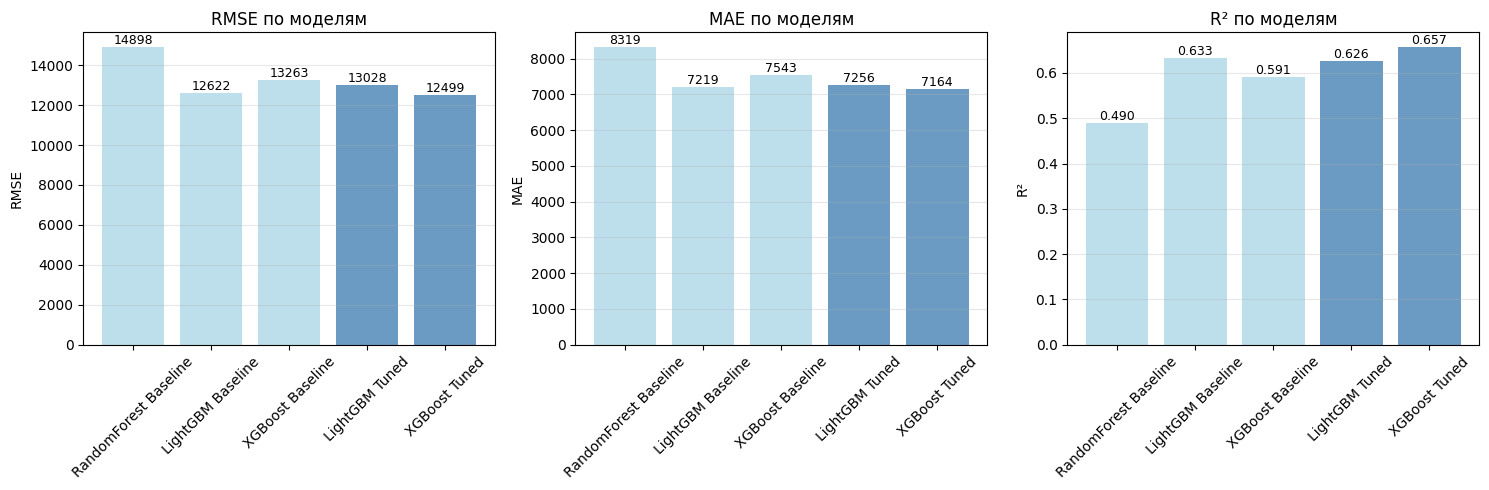


🏆 ВЫБОР ЛУЧШЕЙ МОДЕЛИ

🏆 ЛУЧШАЯ МОДЕЛЬ: XGBoost Tuned
  RMSE: 12498.8 ± 849.0
  MAE: 7164.4 ± 117.5
  R²: 0.657 ± 0.052
  Улучшение от Baseline: 5.8%

🔧 Финальное обучение лучшей модели...
✓ Модель сохранена: ../reports/improvements/models/final_best_log_model.pkl

📋 ФИНАЛЬНЫЙ ОТЧЕТ


In [ ]:
print("🎯 04: ГИПЕРПАРАМЕТРИЧЕСКИЙ ТЮНИНГ (Логарифмирование + XGBoost)")

## 1: Загрузка данных и создание признаков
print("\n📥 Загрузка данных...")

processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
target_col = 'Weekly_Sales'

# Создаем признаки ДО разделения
df_processed = df.copy()
df_processed['day_of_week'] = df_processed['Date'].dt.dayofweek
df_processed['month'] = df_processed['Date'].dt.month
df_processed['week_of_year'] = df_processed['Date'].dt.isocalendar().week
df_processed['quarter'] = df_processed['Date'].dt.quarter
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['is_december'] = (df_processed['month'] == 12).astype(int)
df_processed['is_summer'] = df_processed['month'].isin([6, 7, 8]).astype(int)

df_processed = df_processed.drop(columns=['Date'])
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"✓ Данные: {X.shape[1]} признаков, {X.shape[0]} записей")

## 2: Безопасный трансформер для определения типов признаков
class SafeFeatureIdentifier(BaseEstimator, TransformerMixin):
    """Безопасное определение типов признаков"""
    
    def __init__(self, numeric_features=None, categorical_features=None):
        self.numeric_features_ = numeric_features or []
        self.categorical_features_ = categorical_features or []
        self.is_fitted_ = False
        
    def fit(self, X, y=None):
        if self.numeric_features_ or self.categorical_features_:
            self.is_fitted_ = True
            return self
        
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        self.numeric_features_ = []
        self.categorical_features_ = []
        
        for col in X_df.columns:
            if pd.api.types.is_numeric_dtype(X_df[col]):
                self.numeric_features_.append(col)
            else:
                self.categorical_features_.append(col)
        
        self.is_fitted_ = True
        return self
    
    def transform(self, X):
        if not self.is_fitted_:
            raise ValueError("Transformer must be fitted before transform")
        
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        for col in self.categorical_features_:
            if col in X_df.columns:
                X_df[col] = X_df[col].astype(str).replace('nan', 'missing')
        
        return X_df

## 3: Функция для предварительного определения признаков
def identify_features_safely(X_sample):
    """Определяет типы признаков один раз на небольшой выборке"""
    numeric_features = []
    categorical_features = []
    
    for col in X_sample.columns:
        if pd.api.types.is_numeric_dtype(X_sample[col]):
            if X_sample[col].nunique() <= 30:
                categorical_features.append(col)
            else:
                numeric_features.append(col)
        else:
            categorical_features.append(col)
    
    return numeric_features, categorical_features

## 4: Создание пайплайна с трансформацией цели
def create_pipeline_with_log_transform(estimator, numeric_features, categorical_features):
    """Создает пайплайн с логарифмированием целевой переменной"""
    
    feature_identifier = SafeFeatureIdentifier(
        numeric_features=numeric_features,
        categorical_features=categorical_features
    )
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Проверяем тип модели и создаем совместимый пайплайн
    model_name = estimator.__class__.__name__
    
    if model_name in ['XGBRegressor', 'LGBMRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor']:
        # Эти модели совместимы с sklearn
        return Pipeline(steps=[
            ('feature_identifier', feature_identifier),
            ('preprocessor', preprocessor),
            ('model', estimator)
        ])
    else:
        # Для других моделей используем простой подход
        print(f"⚠️ Модель {model_name} может иметь проблемы совместимости")
        return Pipeline(steps=[
            ('feature_identifier', feature_identifier),
            ('preprocessor', preprocessor),
            ('model', estimator)
        ])

## 5: Функция для оценки с логарифмированием цели
def evaluate_with_log_transform(pipeline, X, y_original, n_splits=3):
    """Оценка модели с логарифмированием целевой переменной"""
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train_orig, y_test_orig = y_original.iloc[train_idx], y_original.iloc[test_idx]
        
        # Логарифмирование целевой переменной
        y_train_log = np.log1p(y_train_orig - y_train_orig.min() + 1)
        
        try:
            # Обучение
            pipeline.fit(X_train, y_train_log)
            
            # Предсказание и обратное преобразование
            y_pred_log = pipeline.predict(X_test)
            y_pred = np.expm1(y_pred_log) + y_train_orig.min() - 1
            
            # Метрики на оригинальных значениях
            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
            mae = mean_absolute_error(y_test_orig, y_pred)
            r2 = r2_score(y_test_orig, y_pred)
            
            fold_results.append({
                'fold': fold,
                'rmse': rmse,
                'mae': mae,
                'r2': r2
            })
            
        except Exception as e:
            print(f"  Ошибка на фолде {fold}: {str(e)[:100]}")
            # Возвращаем плохие метрики для этого фолда
            fold_results.append({
                'fold': fold,
                'rmse': 1e10,
                'mae': 1e10,
                'r2': -1
            })
    
    # Агрегируем результаты
    rmse_values = [r['rmse'] for r in fold_results]
    mae_values = [r['mae'] for r in fold_results]
    r2_values = [r['r2'] for r in fold_results]
    
    return {
        'cv_rmse_mean': np.mean(rmse_values),
        'cv_rmse_std': np.std(rmse_values),
        'cv_mae_mean': np.mean(mae_values),
        'cv_mae_std': np.std(mae_values),
        'cv_r2_mean': np.mean(r2_values),
        'cv_r2_std': np.std(r2_values),
        'fold_results': fold_results
    }

## 6: Безопасный random search с логарифмированием
def random_search_with_log_transform(estimator, param_distributions, X, y_original, 
                                   numeric_features, categorical_features,
                                   n_iter=10, n_splits=3):
    """Random search с логарифмированием цели"""
    
    print(f"Random Search ({n_iter} итераций)")
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    best_score = np.inf
    best_params = None
    
    import random
    
    for i in range(1, n_iter + 1):
        params = {k: random.choice(v) if isinstance(v, list) else v 
                 for k, v in param_distributions.items()}
        
        if i % 5 == 0 or i == 1:
            print(f"  Итерация {i}/{n_iter}", end=" ")
        
        estimator_with_params = estimator.__class__(**estimator.get_params())
        estimator_with_params.set_params(**params)
        
        cv_scores = []
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train_orig, y_test_orig = y_original.iloc[train_idx], y_original.iloc[test_idx]
            
            y_train_log = np.log1p(y_train_orig - y_train_orig.min() + 1)
            
            try:
                pipeline = create_pipeline_with_log_transform(estimator_with_params, 
                                                             numeric_features, categorical_features)
                pipeline.fit(X_train, y_train_log)
                
                y_pred_log = pipeline.predict(X_test)
                y_pred = np.expm1(y_pred_log) + y_train_orig.min() - 1
                score = np.sqrt(mean_squared_error(y_test_orig, y_pred))
                cv_scores.append(score)
            except Exception as e:
                cv_scores.append(1e10)  # Большая ошибка при проблемах
        
        mean_score = np.mean(cv_scores)
        
        if i % 5 == 0 or i == 1:
            print(f"- RMSE: {mean_score:.1f}")
        
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
    
    print(f"\n✓ Лучшие параметры: {best_params}")
    print(f"✓ Лучший RMSE: {best_score:.1f}")
    
    return best_params, best_score

## 7: Определение признаков
print("\n🔍 Определение типов признаков...")
X_sample_for_feature_id = X.iloc[:10000]
numeric_features, categorical_features = identify_features_safely(X_sample_for_feature_id)
print(f"✓ Числовых: {len(numeric_features)}, Категориальных: {len(categorical_features)}")

## 8: Конфигурация моделей (без CatBoost)
print("\n🎯 КОНФИГУРАЦИЯ МОДЕЛЕЙ")

models_config = {
    'RandomForest': {
        'estimator': RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            n_estimators=100
        ),
        'param_distributions': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    'LightGBM': {
        'estimator': LGBMRegressor(
            random_state=42,
            n_jobs=-1,
            n_estimators=100,
            verbose=-1
        ),
        'param_distributions': {
            'n_estimators': [100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50, 100],
            'max_depth': [5, 10, -1],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'estimator': XGBRegressor(
            random_state=42,
            n_jobs=-1,
            n_estimators=100,
            verbosity=0
        ),
        'param_distributions': {
            'n_estimators': [100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
}

## 9: Быстрое сравнение базовых моделей
print("\n📊 СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ (2 фолда)")

baseline_results = {}
for model_name, config in models_config.items():
    print(f"\n{model_name} Baseline...", end=" ")
    
    pipeline = create_pipeline_with_log_transform(config['estimator'], 
                                                 numeric_features, categorical_features)
    
    results = evaluate_with_log_transform(pipeline, X, y, n_splits=2)
    baseline_results[model_name] = results
    
    print(f"RMSE: {results['cv_rmse_mean']:.1f}, R²: {results['cv_r2_mean']:.3f}")

## 10: Тюнинг лучших моделей (топ-2)
print("\n🎯 ТЮНИНГ ЛУЧШИХ МОДЕЛЕЙ")

baseline_rmse = {k: v['cv_rmse_mean'] for k, v in baseline_results.items()}
best_models = sorted(baseline_rmse, key=baseline_rmse.get)[:2]
print(f"Тюнинг: {best_models}")

tuning_results = {}
for model_name in best_models:
    print(f"\n{model_name}...")
    
    best_params, best_rmse = random_search_with_log_transform(
        models_config[model_name]['estimator'],
        models_config[model_name]['param_distributions'],
        X, y,
        numeric_features, categorical_features,
        n_iter=10,
        n_splits=2
    )
    
    tuning_results[model_name] = {
        'best_params': best_params,
        'best_rmse': best_rmse
    }

## 11: Финальная оценка на полных данных
print("\n📊 ФИНАЛЬНАЯ ОЦЕНКА (3 фолда)")

all_models = {}

# Базовые модели
for model_name in models_config.keys():
    all_models[f"{model_name} Baseline"] = {
        'estimator': models_config[model_name]['estimator'],
        'params': models_config[model_name]['estimator'].get_params()
    }

# Настроенные модели
for model_name in tuning_results.keys():
    estimator_cls = models_config[model_name]['estimator'].__class__
    all_models[f"{model_name} Tuned"] = {
        'estimator': estimator_cls(**tuning_results[model_name]['best_params']),
        'params': tuning_results[model_name]['best_params']
    }

final_results = {}
for model_display_name, model_info in all_models.items():
    print(f"  {model_display_name}...", end=" ")
    
    pipeline = create_pipeline_with_log_transform(model_info['estimator'],
                                                 numeric_features, categorical_features)
    
    results = evaluate_with_log_transform(pipeline, X, y, n_splits=3)
    final_results[model_display_name] = results
    
    print(f"RMSE: {results['cv_rmse_mean']:.1f}, R²: {results['cv_r2_mean']:.3f}")

## 12: Сравнение результатов
print("\n📊 ИТОГОВОЕ СРАВНЕНИЕ")

comparison_data = []
for model_name, results in final_results.items():
    comparison_data.append({
        'Модель': model_name,
        'RMSE': results['cv_rmse_mean'],
        'RMSE_std': results['cv_rmse_std'],
        'MAE': results['cv_mae_mean'],
        'MAE_std': results['cv_mae_std'],
        'R²': results['cv_r2_mean'],
        'R²_std': results['cv_r2_std'],
        'Тип': 'Baseline' if 'Baseline' in model_name else 'Tuned'
    })

comparison_df = pd.DataFrame(comparison_data)

# Вычисляем улучшение
for i, row in comparison_df.iterrows():
    if row['Тип'] == 'Tuned':
        base_model = row['Модель'].replace(' Tuned', ' Baseline')
        base_match = comparison_df[comparison_df['Модель'] == base_model]
        if not base_match.empty:
            base_rmse = base_match['RMSE'].values[0]
            improvement = (base_rmse - row['RMSE']) / base_rmse * 100
            comparison_df.loc[i, 'Улучшение RMSE (%)'] = improvement

print("\n" + comparison_df.round({
    'RMSE': 1, 'RMSE_std': 1, 'MAE': 1, 'MAE_std': 1, 
    'R²': 3, 'R²_std': 3, 'Улучшение RMSE (%)': 2
}).to_string())

## 13: Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df['Модель']
rmse_values = comparison_df['RMSE']
mae_values = comparison_df['MAE']
r2_values = comparison_df['R²']
colors = ['lightblue' if 'Baseline' in m else 'steelblue' for m in models]

# RMSE
bars1 = axes[0].bar(models, rmse_values, alpha=0.8, color=colors)
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE по моделям')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars1, rmse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# MAE
bars2 = axes[1].bar(models, mae_values, alpha=0.8, color=colors)
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE по моделям')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars2, mae_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# R²
bars3 = axes[2].bar(models, r2_values, alpha=0.8, color=colors)
axes[2].set_ylabel('R²')
axes[2].set_title('R² по моделям')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/final_comparison_log_transform.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 14: Выбор и сохранение лучшей модели
print("\n🏆 ВЫБОР ЛУЧШЕЙ МОДЕЛИ")

best_model_name = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Модель']
best_model_results = final_results[best_model_name]

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"  RMSE: {best_model_results['cv_rmse_mean']:.1f} ± {best_model_results['cv_rmse_std']:.1f}")
print(f"  MAE: {best_model_results['cv_mae_mean']:.1f} ± {best_model_results['cv_mae_std']:.1f}")
print(f"  R²: {best_model_results['cv_r2_mean']:.3f} ± {best_model_results['cv_r2_std']:.3f}")

if 'Улучшение RMSE (%)' in comparison_df.columns:
    improvement = comparison_df.loc[comparison_df['Модель'] == best_model_name, 'Улучшение RMSE (%)'].values[0]
    if not pd.isna(improvement):
        print(f"  Улучшение от Baseline: {improvement:.1f}%")

print("\n🔧 Финальное обучение лучшей модели...")

if 'Tuned' in best_model_name:
    base_model = best_model_name.replace(' Tuned', '')
    best_params = tuning_results[base_model]['best_params']
    estimator_cls = models_config[base_model]['estimator'].__class__
    final_estimator = estimator_cls(**best_params)
else:
    final_estimator = all_models[best_model_name]['estimator']

final_pipeline = create_pipeline_with_log_transform(final_estimator, 
                                                   numeric_features, categorical_features)

# Обучаем на всех данных с логарифмированием
y_log = np.log1p(y - y.min() + 1)
final_pipeline.fit(X, y_log)

os.makedirs('../reports/improvements/models', exist_ok=True)
model_path = f'../reports/improvements/models/final_best_log_model.pkl'
joblib.dump(final_pipeline, model_path)

print(f"✓ Модель сохранена: {model_path}")

## 15: Финальный отчет
print("\n📋 ФИНАЛЬНЫЙ ОТЧЕТ")

final_report = {
    'timestamp': datetime.now().isoformat(),
    'best_model': {
        'name': best_model_name,
        'parameters': all_models[best_model_name]['params'],
        'performance': {
            'rmse_mean': float(best_model_results['cv_rmse_mean']),
            'rmse_std': float(best_model_results['cv_rmse_std']),
            'mae_mean': float(best_model_results['cv_mae_mean']),
            'mae_std': float(best_model_results['cv_mae_std']),
            'r2_mean': float(best_model_results['cv_r2_mean']),
            'r2_std': float(best_model_results['cv_r2_std'])
        }
    },
    'experiment_settings': {
        'target_transform': 'log1p',
        'models_tested': len(models_config),
        'cv_folds_final': 3,
        'random_search_iterations': 10
    },
    'results_summary': comparison_df.to_dict('records')
}

results_dir = '../reports/improvements/results'
os.makedirs(results_dir, exist_ok=True)

report_path = f'{results_dir}/experiment_4_final_log_report.json'
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False, default=str)

comparison_df.to_csv(f'{results_dir}/experiment_4_final_log_comparison.csv', index=False)